In [1]:
%pip install yfinance
%pip install mplfinance
%pip install statsmodels
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
tickers = ["SBIN.NS", "INFY.NS"]
data = yf.download(tickers, group_by="ticker", period="max")
display(data.head())

[*********************100%***********************]  2 of 2 completed


Ticker       INFY.NS                                          SBIN.NS  \
Price           Open      High       Low     Close  Volume       Open   
Date                                                                    
1996-01-01  0.510868  0.511998  0.508358  0.511998  204800  11.881036   
1996-01-02  0.510868  0.513379  0.509927  0.509927  204800  12.009986   
1996-01-03  0.513379  0.513379  0.513379  0.513379  102400  11.650133   
1996-01-04  0.508358  0.510868  0.508358  0.509990  307200  11.125356   
1996-01-05  0.503965  0.503965  0.503965  0.503965   51200  11.275293   

Ticker                                                   
Price            High        Low      Close      Volume  
Date                                                     
1996-01-01  12.063960  11.785076  11.965001  43733533.0  
1996-01-02  12.054967  11.275293  11.584165  56167280.0  
1996-01-03  11.803068  11.215314  11.275290  68296318.0  
1996-01-04  11.335267  10.948429  11.236309  86073880.0  
1996-01-05  11.305280  11.098367  11.173336  76613039.0

In [4]:
transformed_data = pd.DataFrame({
    'SBIN_Close': data['SBIN.NS']['Close'],
    'INFY_Close': data['INFY.NS']['Close']
})

display(transformed_data.head())

,SBIN_Close,INFY_Close
Date,,
1996-01-01,11.965001,0.511998
1996-01-02,11.584165,0.509927
1996-01-03,11.275290,0.513379
1996-01-04,11.236309,0.509990
1996-01-05,11.173336,0.503965


In [5]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7456 entries, 1996-01-01 to 2025-09-08
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SBIN_Close  7454 non-null   float64
 1   INFY_Close  7456 non-null   float64
dtypes: float64(2)
memory usage: 174.8 KB


In [6]:
# Display rows with missing values
transformed_data[transformed_data.isnull().any(axis=1)]

,SBIN_Close,INFY_Close
Date,,
2004-04-26,NaN,55.334080
2004-10-13,NaN,71.572845


In [7]:
# Drop the rows with missing values since market was closed
transformed_data = transformed_data.drop(index=['2004-04-26', '2004-10-13'])

In [8]:
transformed_data.describe()

,SBIN_Close,INFY_Close
count,7454.000000,7454.000000
mean,192.594362,415.533832
std,199.743775,505.108860
min,9.189685,0.490471
25%,19.946013,56.164667
50%,159.927307,219.964645
75%,252.459534,480.617752
max,887.822937,1971.954346


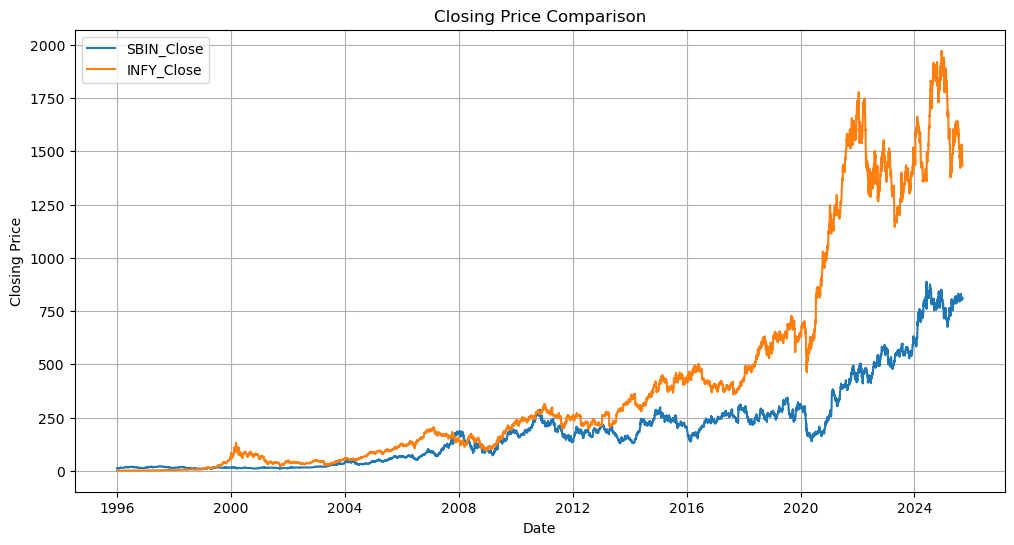

In [9]:
# Plot the transformed data
plt.figure(figsize=(12, 6))
plt.plot(transformed_data.index, transformed_data['SBIN_Close'], label='SBIN_Close')
plt.plot(transformed_data.index, transformed_data['INFY_Close'], label='INFY_Close')
plt.title('Closing Price Comparison')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

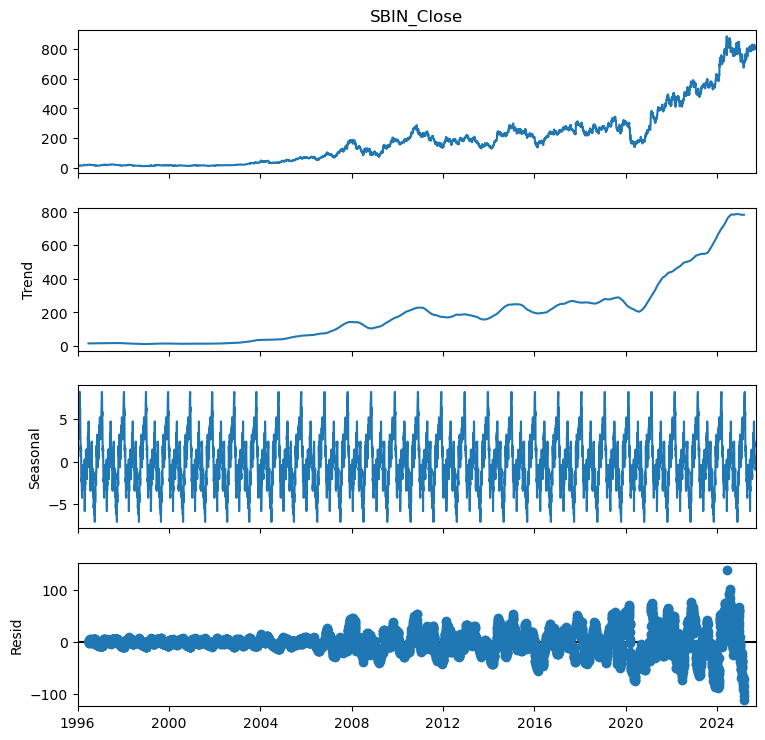

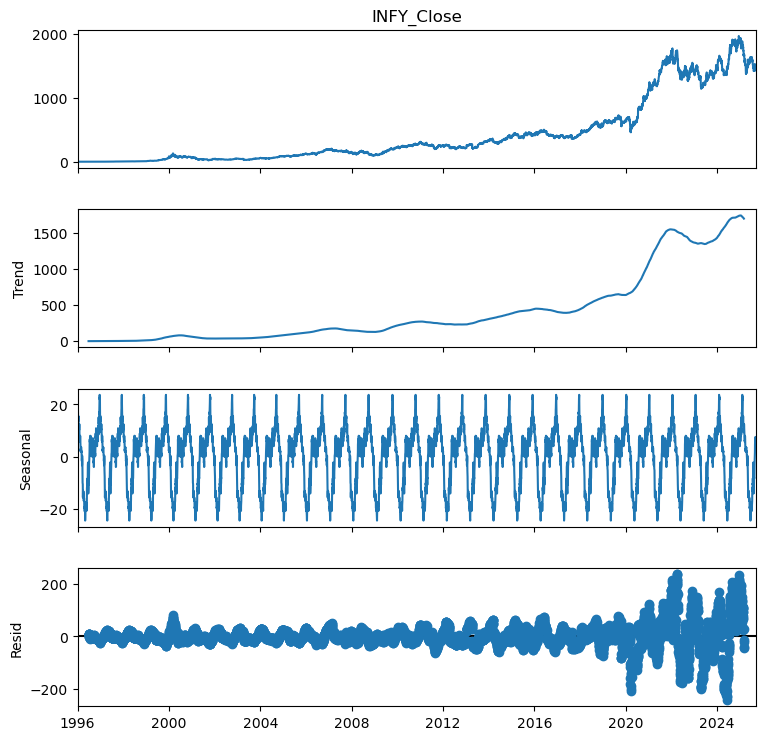

In [10]:
transformed_data.index = pd.to_datetime(transformed_data.index)

# Decompose SBIN_Close
decomp_sbi = seasonal_decompose(transformed_data['SBIN_Close'], model='additive', period=252)
fig1 = decomp_sbi.plot().set_size_inches(8, 8)
plt.show()

# Decompose INFY_Close
decomp_infy = seasonal_decompose(transformed_data['INFY_Close'], model='additive', period=252)
fig2 = decomp_infy.plot().set_size_inches(8, 8)
plt.show()

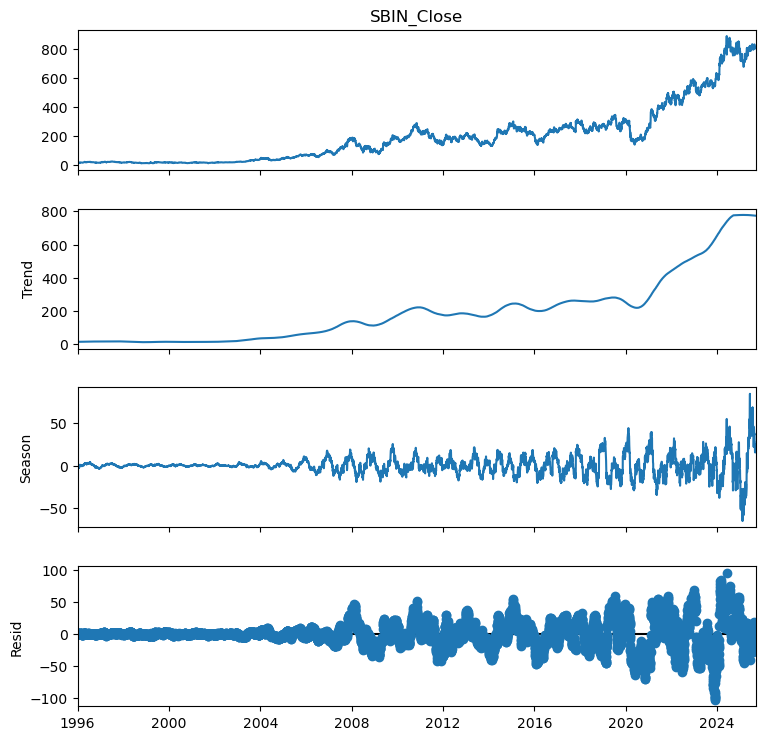

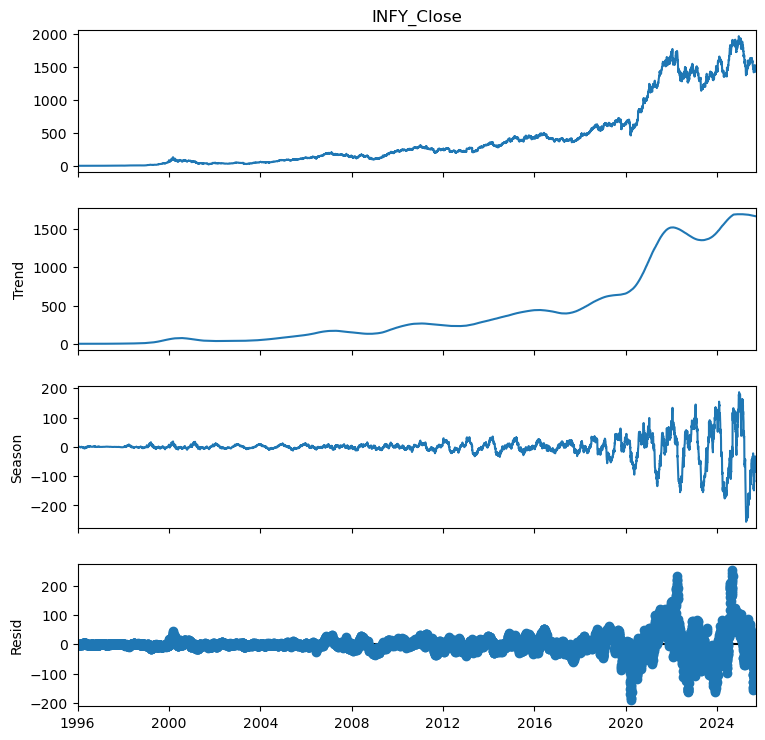

In [11]:
# STL decomposition for SBIN_Close
stl_sbin = STL(transformed_data['SBIN_Close'], period=252).fit()
fig_stl_sbin = stl_sbin.plot().set_size_inches(8, 8)
plt.show()

# STL decomposition for INFY_Close
stl_infy = STL(transformed_data['INFY_Close'], period=252).fit()
fig_stl_infy = stl_infy.plot().set_size_inches(8, 8)
plt.show()

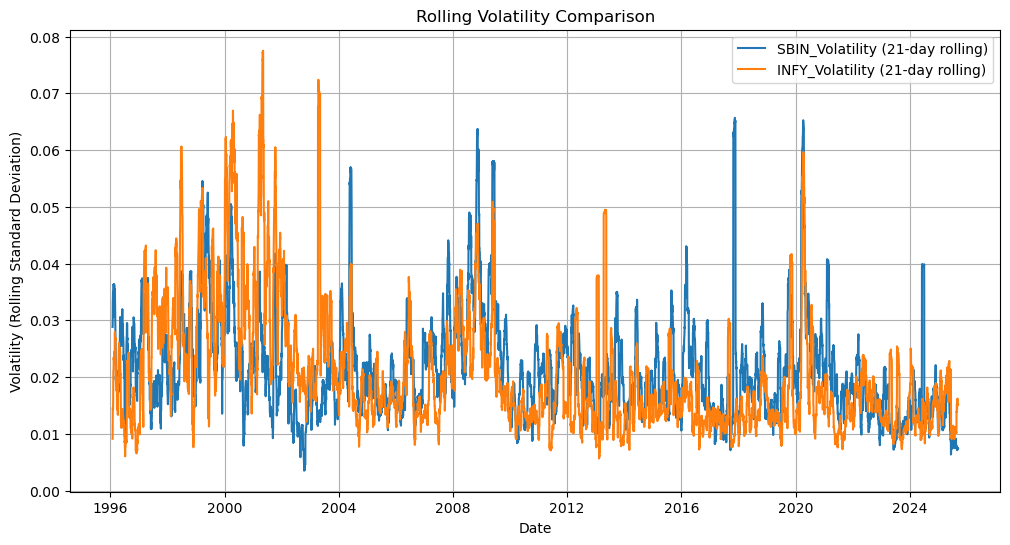

In [12]:
# Calculate daily returns percentage
transformed_data['SBIN_Returns'] = transformed_data['SBIN_Close'].pct_change()
transformed_data['INFY_Returns'] = transformed_data['INFY_Close'].pct_change()

rolling_window = 21 # Approx one trading month
transformed_data['SBIN_Volatility'] = transformed_data['SBIN_Returns'].rolling(window=rolling_window).std()
transformed_data['INFY_Volatility'] = transformed_data['INFY_Returns'].rolling(window=rolling_window).std()

# Plot the rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(transformed_data.index, transformed_data['SBIN_Volatility'], label=f'SBIN_Volatility ({rolling_window}-day rolling)')
plt.plot(transformed_data.index, transformed_data['INFY_Volatility'], label=f'INFY_Volatility ({rolling_window}-day rolling)')
plt.title('Rolling Volatility Comparison')
plt.xlabel('Date')
plt.ylabel('Volatility (Rolling Standard Deviation)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller

# Define a function for the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', 'Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis (H0), the series is stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis (H0), the series is not stationary.")
    print('=============')

# Perform ADF test on SBIN_Close
adf_test(transformed_data['SBIN_Close'], title='SBIN_Close')

# Perform ADF test on INFY_Close
adf_test(transformed_data['INFY_Close'], title='INFY_Close')

Augmented Dickey-Fuller Test: SBIN_Close
ADF Statistic: 1.0953148788580067
p-value: 0.9951764379599396
Lags Used: 34
Number of Observations Used: 7419
Conclusion: Fail to reject the null hypothesis (H0), the series is not stationary.
Augmented Dickey-Fuller Test: INFY_Close
ADF Statistic: 0.069204635065506
p-value: 0.9638945583113675
Lags Used: 31
Number of Observations Used: 7422
Conclusion: Fail to reject the null hypothesis (H0), the series is not stationary.


In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
from statsmodels.tsa.stattools import kpss

# Define a function for the Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    statistic, p_value, n_lags, critical_values = kpss(series.dropna())
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Number of Lags Used: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    if p_value <= 0.05:
        print("Conclusion: Reject the null hypothesis (H0), the series is not stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis (H0), the series is stationary.")
    print('=====================')

# Perform KPSS test on SBIN_Close
kpss_test(transformed_data['SBIN_Close'], title='SBIN_Close')

# Perform KPSS test on INFY_Close
kpss_test(transformed_data['INFY_Close'], title='INFY_Close')

KPSS Test: SBIN_Close
KPSS Statistic: 10.34868552529327
p-value: 0.01
Number of Lags Used: 53
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject the null hypothesis (H0), the series is not stationary.
KPSS Test: INFY_Close
KPSS Statistic: 10.255028996024858
p-value: 0.01
Number of Lags Used: 53
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject the null hypothesis (H0), the series is not stationary.


In [16]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences required for SBIN_Close
n_diffs_sbin = ndiffs(transformed_data['SBIN_Close'].dropna(), test='adf')
print(f"Estimated number of differences required for SBIN_Close: {n_diffs_sbin}")

# Estimate the number of differences required for INFY_Close
n_diffs_infy = ndiffs(transformed_data['INFY_Close'].dropna(), test='adf')
print(f"Estimated number of differences required for INFY_Close: {n_diffs_infy}") # Try: test='kpss', 'pp' also 

Estimated number of differences required for SBIN_Close: 1
Estimated number of differences required for INFY_Close: 1


In [17]:
# Apply first-order differencing
transformed_data['SBIN_Close_diff'] = transformed_data['SBIN_Close'].diff().dropna()
transformed_data['INFY_Close_diff'] = transformed_data['INFY_Close'].diff().dropna()

# Perform ADF test on differenced series
adf_test(transformed_data['SBIN_Close_diff'], title='SBIN_Close First Difference')
adf_test(transformed_data['INFY_Close_diff'], title='INFY_Close First Difference')

# Perform KPSS test on differenced series
kpss_test(transformed_data['SBIN_Close_diff'], title='SBIN_Close First Difference')
kpss_test(transformed_data['INFY_Close_diff'], title='INFY_Close First Difference')

Augmented Dickey-Fuller Test: SBIN_Close First Difference
ADF Statistic: -14.700247938043487
p-value: 2.9544148409224612e-27
Lags Used: 33
Number of Observations Used: 7419
Conclusion: Reject the null hypothesis (H0), the series is stationary.
Augmented Dickey-Fuller Test: INFY_Close First Difference
ADF Statistic: -14.941007139265636
p-value: 1.3226213270344145e-27
Lags Used: 36
Number of Observations Used: 7416
Conclusion: Reject the null hypothesis (H0), the series is stationary.
KPSS Test: SBIN_Close First Difference
KPSS Statistic: 0.3512215829928605
p-value: 0.09818035215824979
Number of Lags Used: 9
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Fail to reject the null hypothesis (H0), the series is stationary.
KPSS Test: INFY_Close First Difference
KPSS Statistic: 0.2040984678604438
p-value: 0.1
Number of Lags Used: 0
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Fail to reject the null hypothesis (H0), 

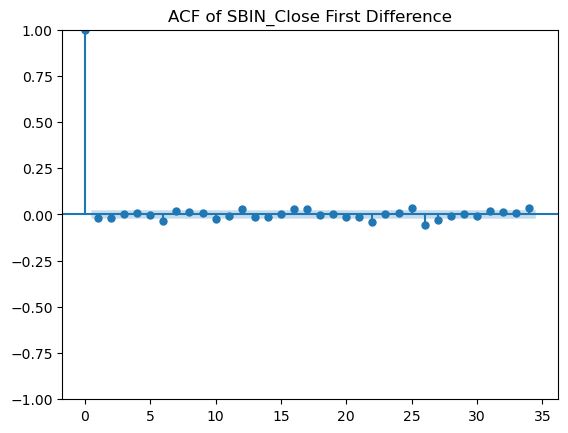

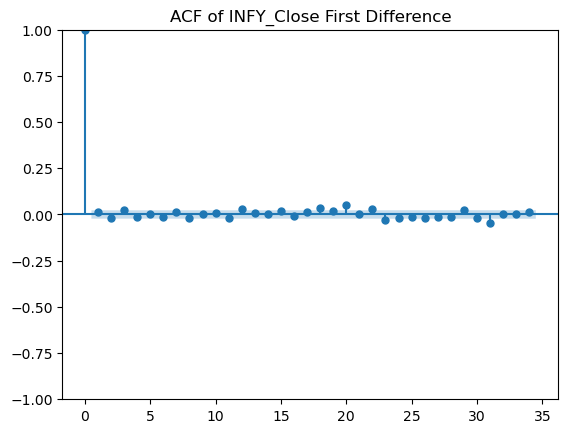

In [18]:
# Plot ACF for SBIN_Close_diff
plot_acf(transformed_data['SBIN_Close_diff'].dropna(), lags=34, title='ACF of SBIN_Close First Difference')
plt.show()

# Plot ACF for INFY_Close_diff
plot_acf(transformed_data['INFY_Close_diff'].dropna(), lags=34, title='ACF of INFY_Close First Difference')
plt.show()

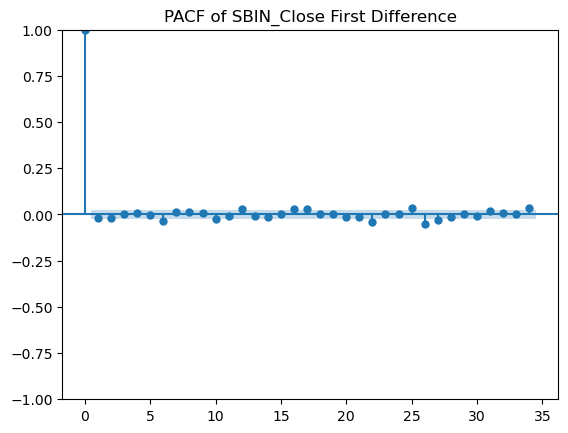

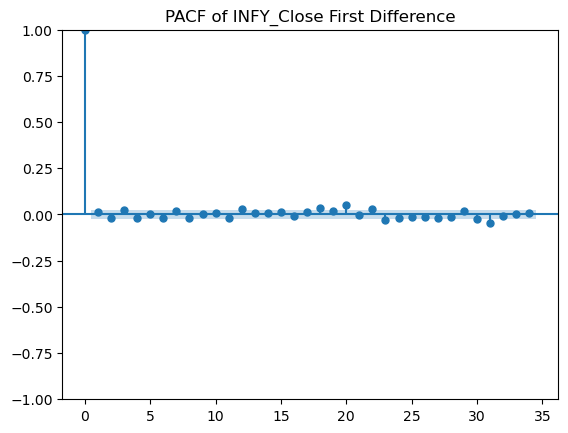

In [19]:
# Plot PACF for SBIN_Close_diff
plot_pacf(transformed_data['SBIN_Close_diff'].dropna(), lags=34, title='PACF of SBIN_Close First Difference')
plt.show()

# Plot PACF for INFY_Close_diff
plot_pacf(transformed_data['INFY_Close_diff'].dropna(), lags=34, title='PACF of INFY_Close First Difference')
plt.show()

In [20]:
# Perform train-test split
train_size = int(len(transformed_data) * 0.95) # 95% for training
train_data, test_data = transformed_data[0:train_size], transformed_data[train_size:]

print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (7081, 8)
Test data shape: (373, 8)


In [21]:
import pmdarima as pm
def find_best_arima_model(time_series):
    print("Searching for the best ARIMA model...")
    best_model = pm.auto_arima(time_series,
                               start_p=1,
                               start_q=1,
                               max_p=7,          # Maximum value for p to test
                               max_q=7,           # determine d automatically
                               start_P = 0, 
                               m = 3,
                               test='adf',       # ADF test to find order of differencing
                               seasonal=False,   # No seasonality
                               trace=True,
                               error_action='ignore',
                               D = 1,
                               suppress_warnings=True,
                               stepwise=True)    # Stepwise algorithm to speed up the search7

    print("\n===== Best Model Summary ======")
    print(best_model.summary())
    
    return best_model

In [22]:
# Best sbi model
best_sbi_model = find_best_arima_model(train_data['SBIN_Close'])

Searching for the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40333.481, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40343.972, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40331.822, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40331.637, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40346.447, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40333.446, Time=1.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40333.512, Time=3.88 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40333.744, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 9.457 seconds

===== Best Model Summary ======
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7081
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -20162.818
Date:                Mon, 08 Sep 202

In [23]:
# Best infy model
best_infy_model = find_best_arima_model(train_data['INFY_Close'])

Searching for the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51106.900, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51132.925, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51123.342, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51122.396, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51135.125, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51116.593, Time=1.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51116.573, Time=2.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51114.740, Time=1.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51114.676, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51109.774, Time=5.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51108.943, Time=0.89 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.739 seconds

===== Best Model Summary ======
                               SARIMAX Results                         

In [24]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Forecast on test_data
forecast_sbin, sbin_conf_int = best_sbi_model.predict(n_periods=len(test_data), return_conf_int=True)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_data['SBIN_Close'], forecast_sbin))
print(f"RMSE: {rmse:.4f}")

# Compute MAPE
mape = mean_absolute_percentage_error(test_data['SBIN_Close'], forecast_sbin) * 100
print(f"MAPE: {mape:.2f}%")

# Print Confidence interval
conf_int = pd.DataFrame(sbin_conf_int, index=test_data.index, columns=['Lower', 'Upper'])
print(conf_int.head(2))

RMSE: 41.8137
MAPE: 4.28%
                 Lower       Upper
Date                              
2024-03-06  748.278230  764.640644
2024-03-07  744.729769  768.399360


In [25]:
# Forecast on test_data
forecast_infy, infy_conf_int = best_infy_model.predict(n_periods=len(test_data), return_conf_int=True)

# Compute rmse
rmse = np.sqrt(mean_squared_error(test_data['INFY_Close'], forecast_infy))
print(f"RMSE: {rmse:.4f}")

# Compute MAPE
mape = mean_absolute_percentage_error(test_data['INFY_Close'], forecast_infy) * 100
print(f"MAPE: {mape:.2f}%")

# Print Confidence interval
conf_int = pd.DataFrame(infy_conf_int, index=test_data.index, columns=['Lower', 'Upper'])
print(conf_int.head(2))

RMSE: 195.4361
MAPE: 9.80%
                  Lower        Upper
Date                                
2024-03-06  1526.569379  1561.585815
2024-03-07  1519.517873  1569.994809


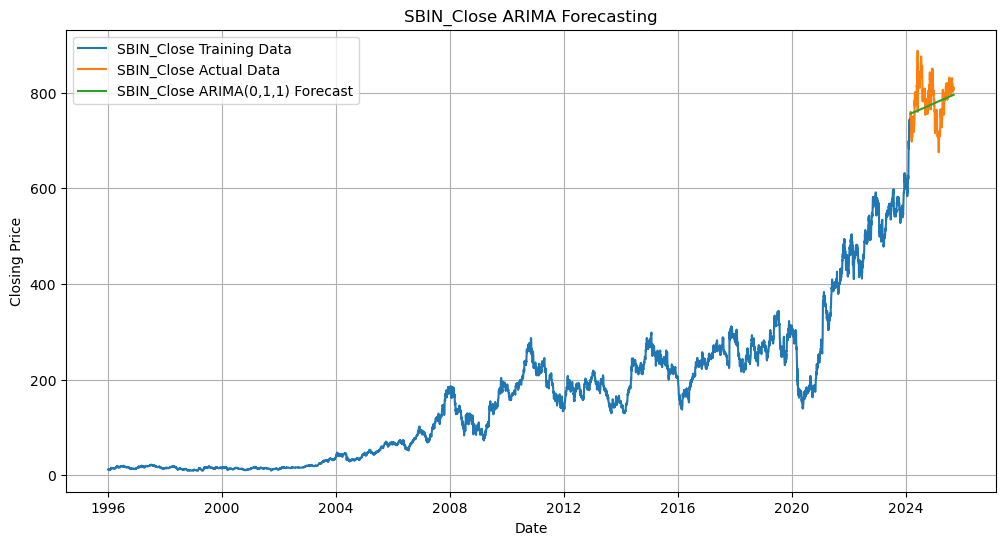

In [26]:
# Plot ARIMA forecast for SBIN_Close
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['SBIN_Close'], label='SBIN_Close Training Data')
plt.plot(test_data.index, test_data['SBIN_Close'], label='SBIN_Close Actual Data')

plt.plot(test_data.index, forecast_sbin, label=f'SBIN_Close ARIMA(0,1,1) Forecast')
plt.title('SBIN_Close ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

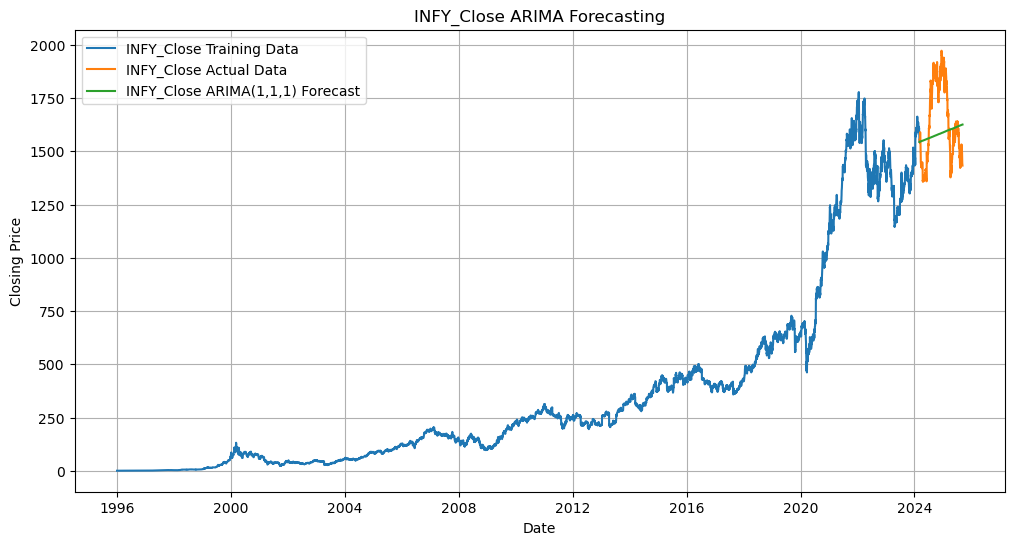

In [27]:
# Plot ARIMA forecast for INFY_Close
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['INFY_Close'], label='INFY_Close Training Data')
plt.plot(test_data.index, test_data['INFY_Close'], label='INFY_Close Actual Data')

plt.plot(test_data.index, forecast_infy, label=f'INFY_Close ARIMA(1,1,1) Forecast')
plt.title('INFY_Close ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

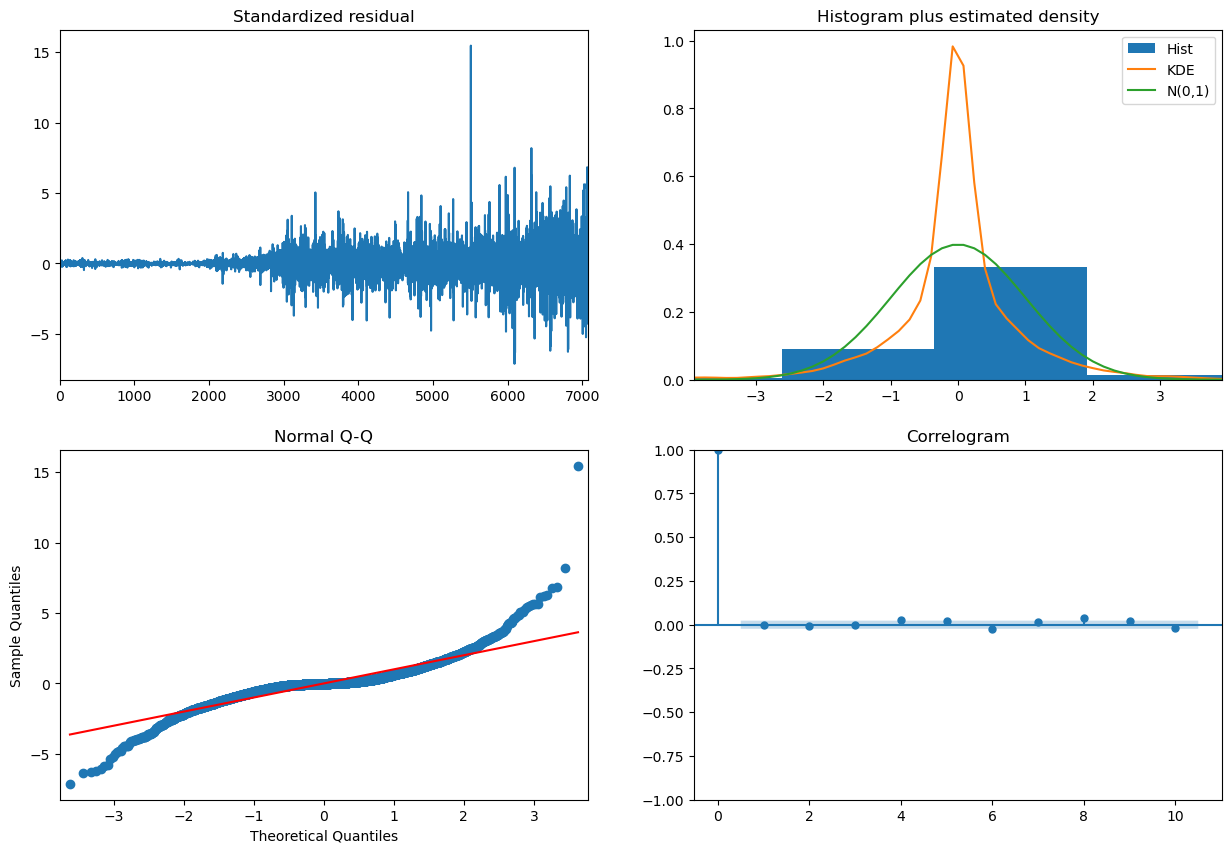

In [28]:
# --- ARIMA Model Diagnostics for SBIN ---
best_sbi_model.plot_diagnostics(figsize=(15, 10))
plt.show()

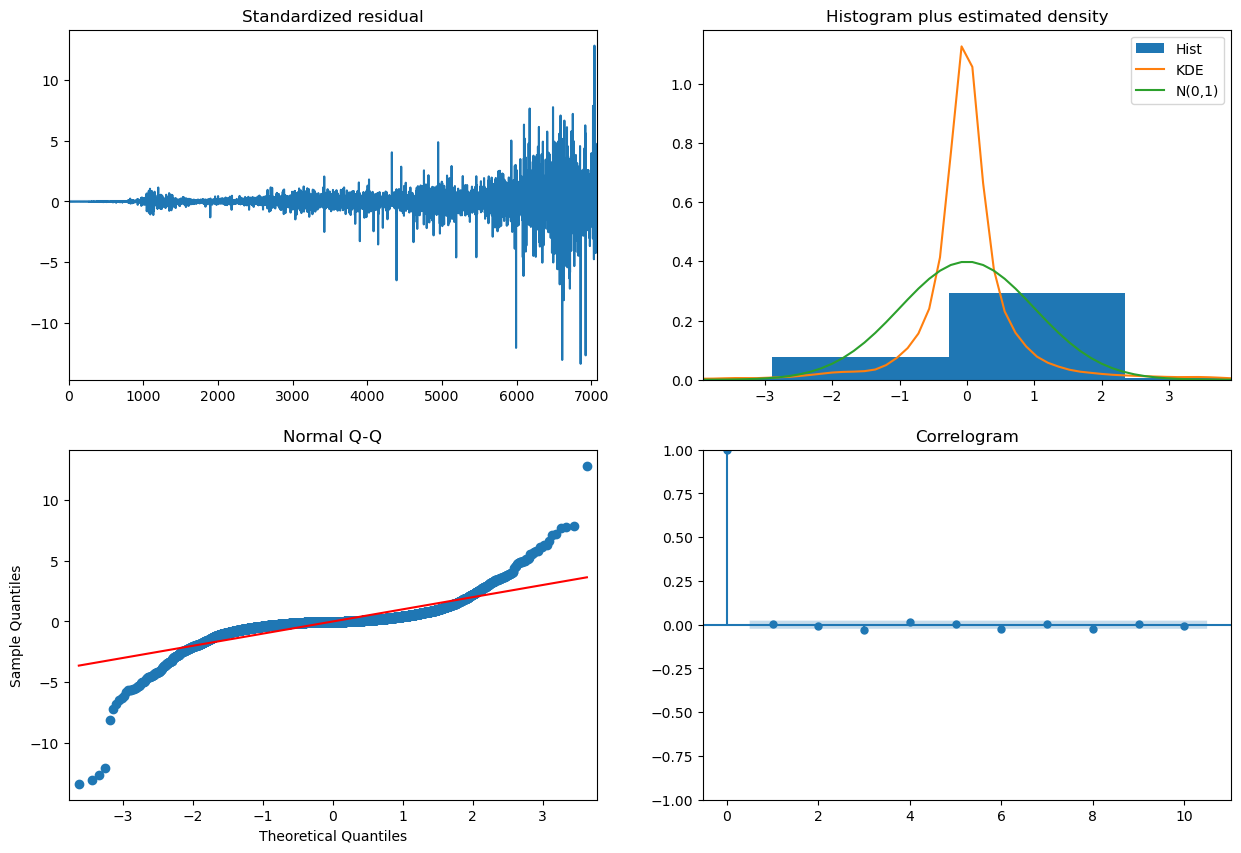

In [29]:
# --- ARIMA Model Diagnostics for INFY ---
best_infy_model.plot_diagnostics(figsize=(15, 10))
plt.show()

In [30]:
#=====================================================================#==================================#

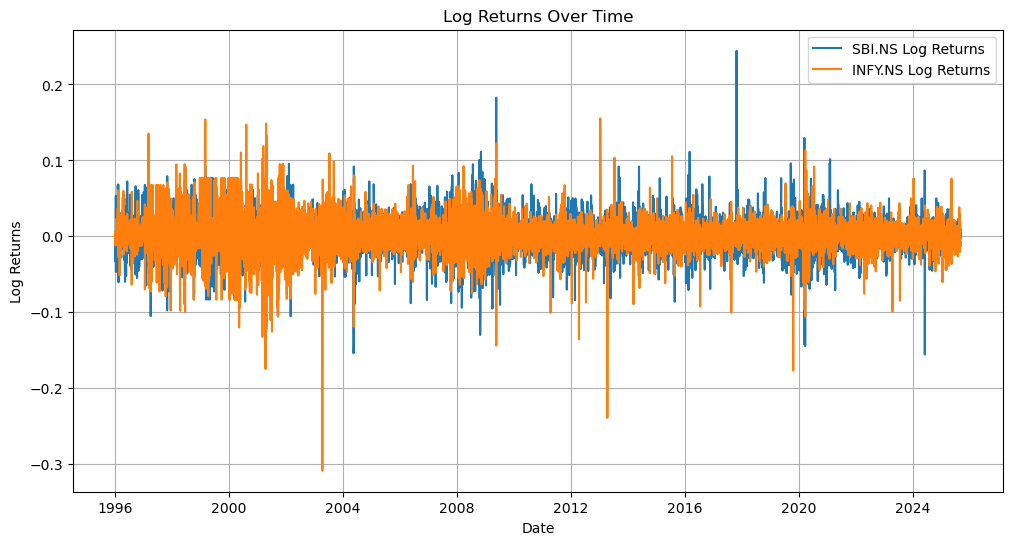

In [31]:
transformed_data = transformed_data.iloc[:, 0:2]
transformed_data['SBIN_log_returns'] = np.log(transformed_data['SBIN_Close']/transformed_data['SBIN_Close'].shift(1))
transformed_data['INFY_log_returns'] = np.log(transformed_data['INFY_Close']/transformed_data['INFY_Close'].shift(1))

plt.figure(figsize=(12, 6))
plt.plot(transformed_data['SBIN_log_returns'].dropna().index, transformed_data['SBIN_log_returns'].dropna(), label='SBI.NS Log Returns')
plt.plot(transformed_data['INFY_log_returns'].dropna().index, transformed_data['INFY_log_returns'].dropna(), label='INFY.NS Log Returns')
plt.title('Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
transformed_data['SBIN_log_scale']=transformed_data['SBIN_log_returns']*100
transformed_data['INFY_log_scale']=transformed_data['INFY_log_returns']*100

In [33]:
from statsmodels.stats.diagnostic import het_arch

def arch_test(series, nlags=None):
    series = series.dropna()
    test_stat, p_value, f_stat, f_p_value = het_arch(series, nlags=nlags)

    # Print nicely
    print(f"ARCH Test Statistic: {test_stat:.4f}")
    print(f"ARCH Test p-value: {p_value:.4f}")
    print(f"ARCH Test F-statistic: {f_stat:.4f}")
    print(f"ARCH Test F-Test p-value: {f_p_value:.4f}")

In [51]:
arch_test(transformed_data['SBIN_log_scale'], nlags=21)

ARCH Test Statistic: 498.2796
ARCH Test p-value: 0.0000
ARCH Test F-statistic: 25.3575
ARCH Test F-Test p-value: 0.0000


In [52]:
arch_test(transformed_data['INFY_log_scale'], nlags=21)

ARCH Test Statistic: 518.4773
ARCH Test p-value: 0.0000
ARCH Test F-statistic: 26.4624
ARCH Test F-Test p-value: 0.0000


##### Therefore, the low p-value suggests that there are statistically significant ARCH effects present in the both log returns.

In [36]:
%pip install arch

Note: you may need to restart the kernel to use updated packages.


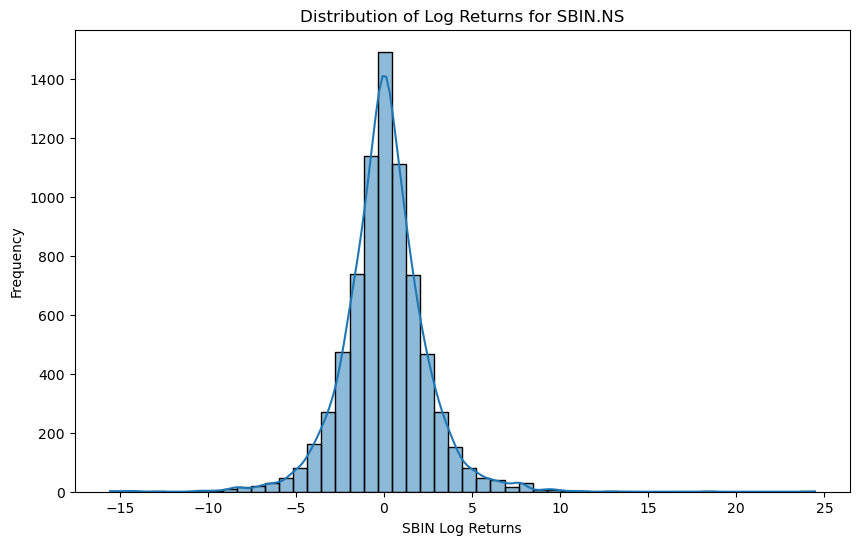

In [56]:
import seaborn as sns

# Plot the distribution of log returns
plt.figure(figsize=(10, 6))
sns.histplot(transformed_data['SBIN_log_scale'].dropna(), kde=True, bins=50)
plt.title('Distribution of Log Returns for SBIN.NS')
plt.xlabel('SBIN Log Returns')
plt.ylabel('Frequency')
plt.show()

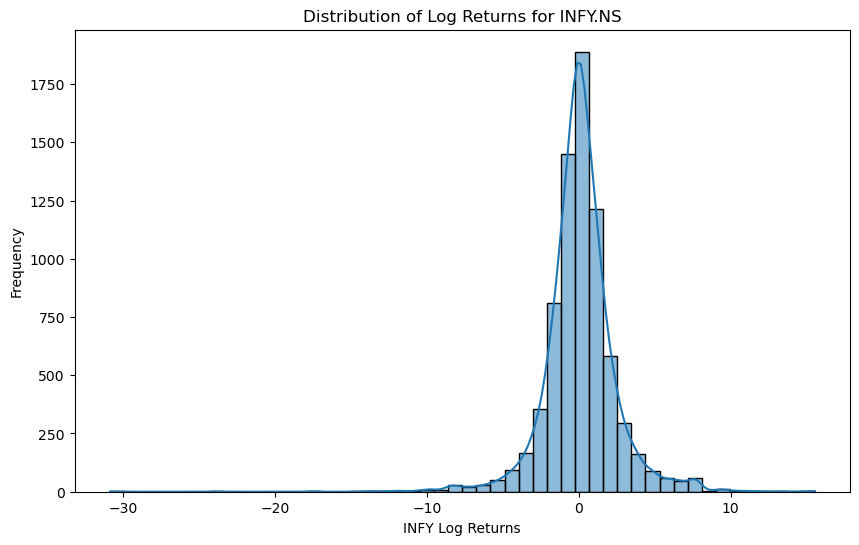

In [55]:
# Plot the distribution of log returns
plt.figure(figsize=(10, 6))
sns.histplot(transformed_data['INFY_log_scale'].dropna(), kde=True, bins=50)
plt.title('Distribution of Log Returns for INFY.NS')
plt.xlabel('INFY Log Returns')
plt.ylabel('Frequency')
plt.show()

In [58]:
# Perform train-test split
train_size = int(len(transformed_data) * 0.95) # 95% for training
train_data, test_data = transformed_data[0:train_size], transformed_data[train_size:]

print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (7081, 6)
Test data shape: (373, 6)


In [72]:
from arch import arch_model
def best_garch_model(series, p_max=7, q_max=7, dist='t'):
    series = series.dropna()
    best_model = None
    best_aic = np.inf
    best_order = None

    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):
            try:
                model = arch_model(series, vol='Garch', p=p, q=q, dist=dist)
                fit = model.fit(disp='off')
                if fit.aic < best_aic:
                    best_aic = fit.aic
                    best_model = fit
                    best_order = (p, q)
            except Exception as e:
                print(f"Skipped p={p}, q={q} due to error: {e}")
                continue

    print(f"\n Best GARCH Model: GARCH{best_order} with AIC = {best_aic:.4f}")
    print("\nModel Coefficients (t-stats and p-values):")
    print(best_model.summary())
    
    return best_model, best_order

In [61]:
def rolling_forecast(train, test, best_order, dist='t'):
    history = train.tolist()
    predictions = []

    for t in range(len(test)):
        model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
        fit = model.fit(disp='off')
        pred = fit.forecast(horizon=1)
        predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
        history.append(test[t])

    return pd.Series(predictions, index=test.index)

In [62]:
def actual_rolling_std(train, test, window=20):
    extended_test = pd.concat([train.iloc[-window:], test])
    rolling_std = extended_test.rolling(window).std()
    return rolling_std[-len(test):]

In [63]:
def compute_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [64]:
def plot_volatility(test_index, actual, predicted, best_order):
    plt.figure(figsize=(14, 7))
    plt.plot(test_index, actual, label='Actual Rolling Std Dev')
    plt.plot(test_index, predicted, label='Predicted Volatility', color='red')
    plt.title(f'Actual Rolling Std Dev vs Predicted Volatility (GARCH{best_order})')
    plt.xlabel('Date')
    plt.ylabel('Volatility / Std Dev')
    plt.legend()
    plt.show()

=========================================SBIN.NS=======================================

 Best GARCH Model: GARCH(1, 2) with AIC = 30759.0348

Model Coefficients (t-stats and p-values):
                        Constant Mean - GARCH Model Results                         
Dep. Variable:               SBIN_log_scale   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -15373.5
Distribution:      Standardized Student's t   AIC:                           30759.0
Method:                  Maximum Likelihood   BIC:                           30800.2
                                              No. Observations:                 7080
Date:                      Mon, Sep 08 2025   Df Residuals:                     7079
Time:                              16:53:25   Df Model:                            1
                                Mean Model       

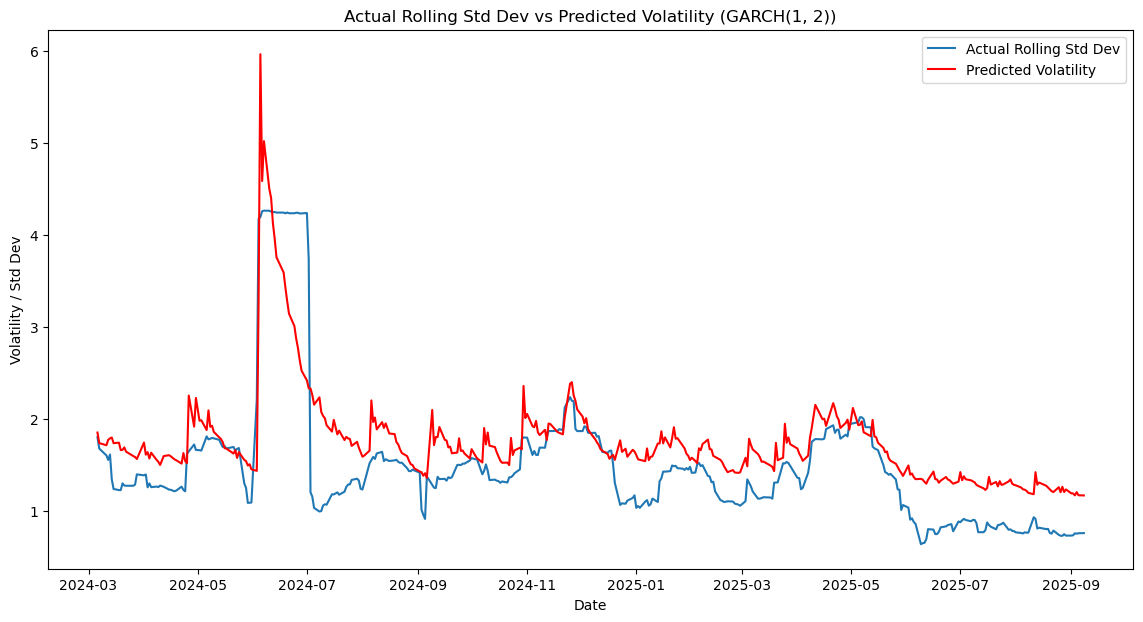

In [84]:
train=train_data['SBIN_log_scale'].dropna()
test=test_data['SBIN_log_scale'].dropna()
print("=========================================SBIN.NS=======================================")

# Find best model
best_model_sbin, best_order_sbin = best_garch_model(train)

# Rolling forecast
rolling_pred = rolling_forecast(train, test, best_order_sbin)

# Actual rolling std
rolling_std_actual = actual_rolling_std(train, test, window=20)

# RMSE
rmse = compute_rmse(rolling_std_actual, rolling_pred)
print(f"RMSE: {rmse:.4f}")

# Plot
plot_volatility(test.index, rolling_std_actual, rolling_pred, best_order_sbin)

=========================================INFY.NS=======================================

 Best GARCH Model: GARCH(1, 5) with AIC = 29467.1617

Model Coefficients (t-stats and p-values):
                        Constant Mean - GARCH Model Results                         
Dep. Variable:               INFY_log_scale   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -14724.6
Distribution:      Standardized Student's t   AIC:                           29467.2
Method:                  Maximum Likelihood   BIC:                           29528.9
                                              No. Observations:                 7080
Date:                      Mon, Sep 08 2025   Df Residuals:                     7079
Time:                              16:54:16   Df Model:                            1
                                Mean Model       

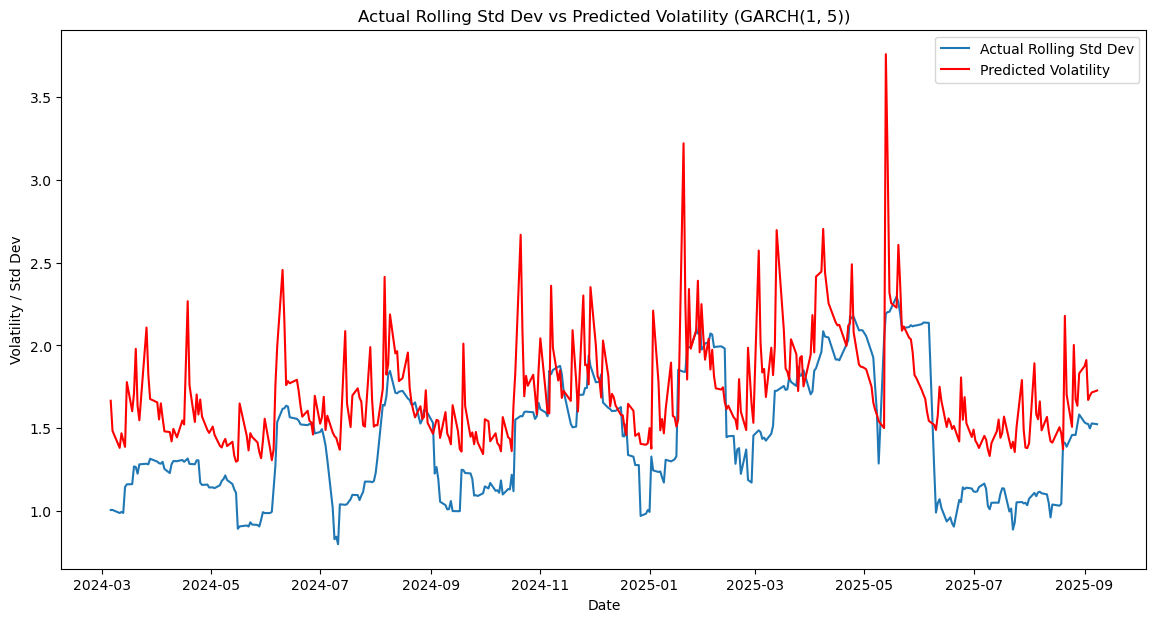

In [85]:
train=train_data['INFY_log_scale'].dropna()
test=test_data['INFY_log_scale'].dropna()
print("=========================================INFY.NS=======================================")
# Find best model
best_model_infy, best_order_infy = best_garch_model(train)

# Rolling forecast
rolling_pred = rolling_forecast(train, test, best_order_infy)

# Actual rolling std
rolling_std_actual = actual_rolling_std(train, test, window=20)

# RMSE
rmse = compute_rmse(rolling_std_actual, rolling_pred)
print(f"RMSE: {rmse:.4f}")

# Plot
plot_volatility(test.index, rolling_std_actual, rolling_pred, best_order_infy)

=========================================SBIN.NS=======================================


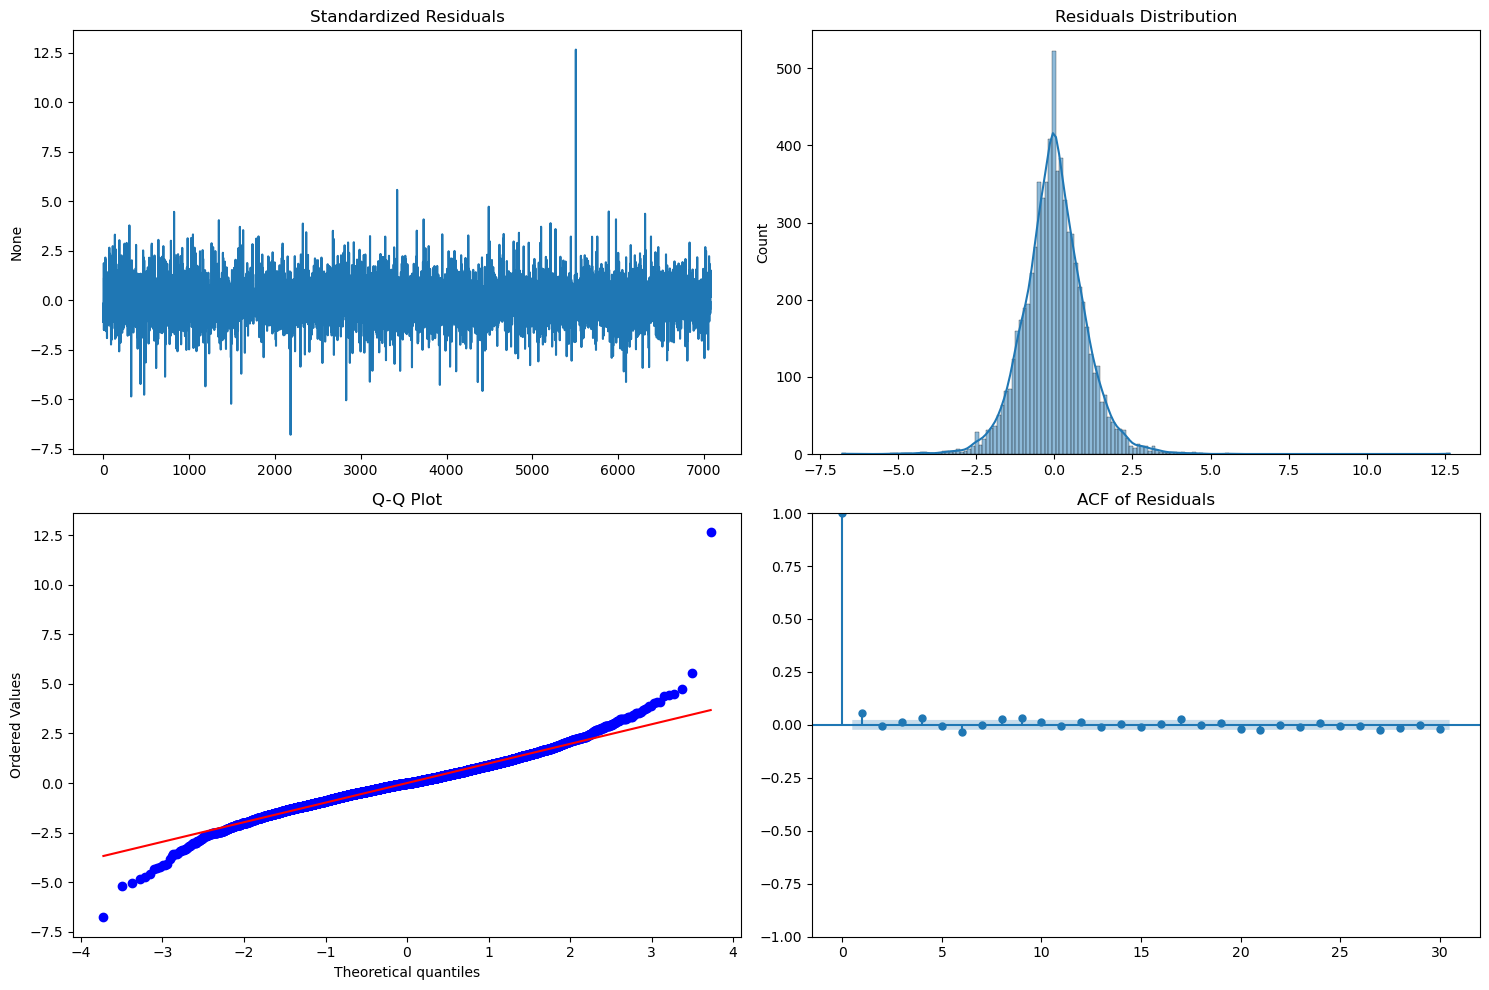

In [ ]:
from scipy import stats
residuals = best_model_sbin.resid / best_model_sbin.conditional_volatility
print("=========================================SBIN.NS=======================================")
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Standardized Residuals")

# Histogram & KDE
sns.histplot(residuals, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Distribution")

#  Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Q-Q Plot")

#  ACF Plot
plot_acf(residuals, lags=30, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

=========================================INFY.NS=======================================


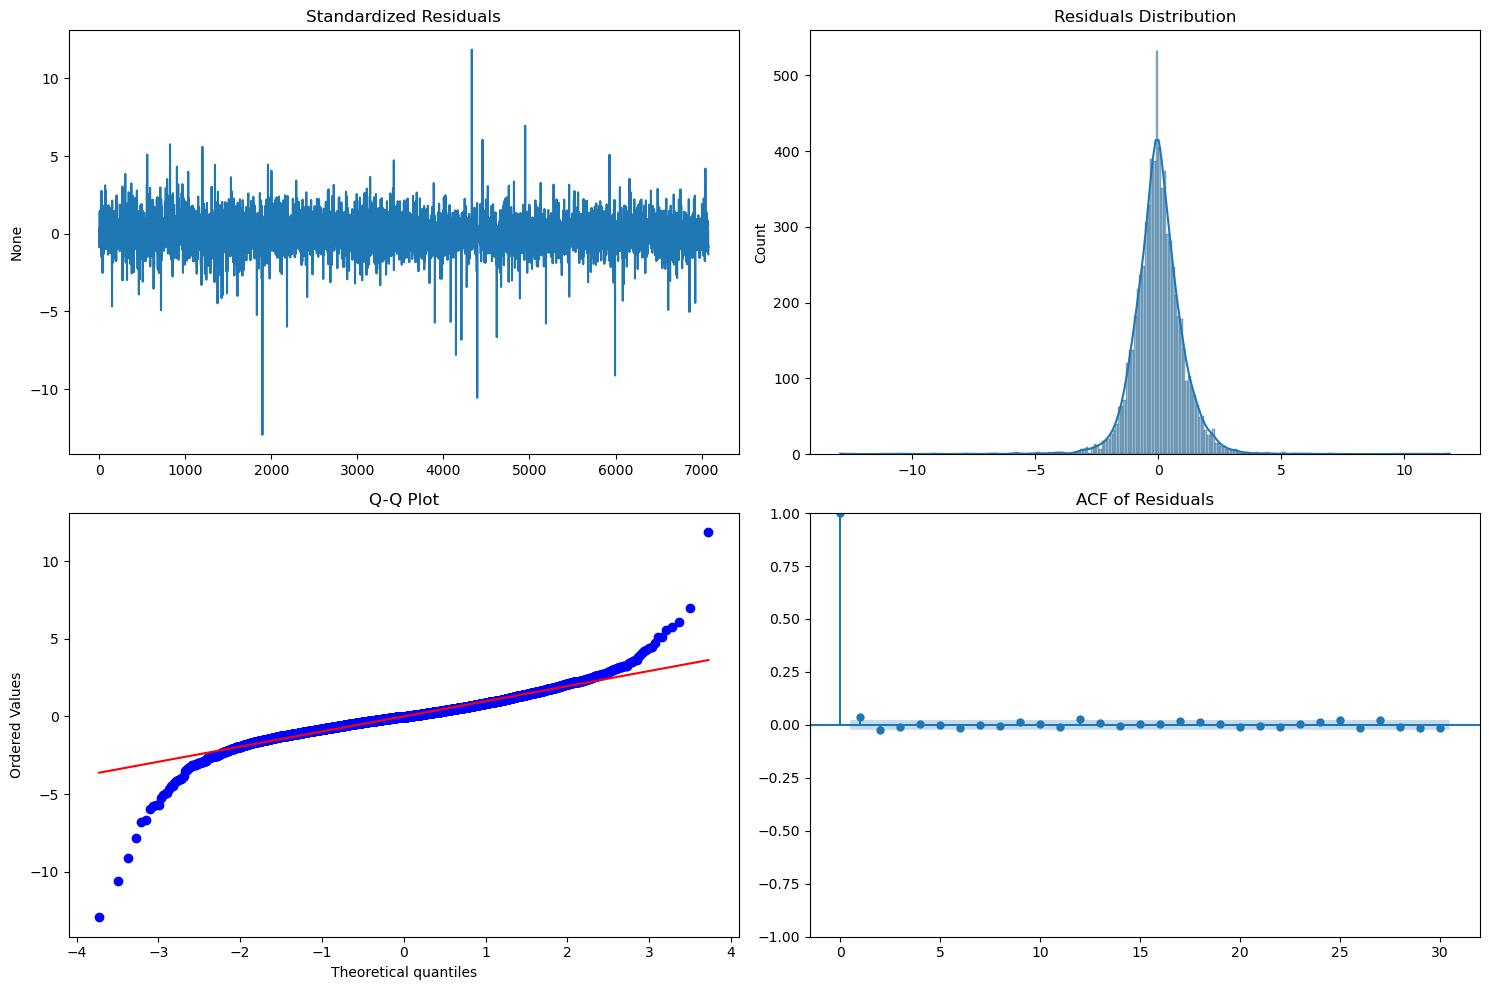

In [147]:
from scipy import stats
residuals = best_model_infy.resid / best_model_infy.conditional_volatility
print("=========================================INFY.NS=======================================")
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Standardized Residuals")

# Histogram & KDE
sns.histplot(residuals, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Distribution")

#  Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Q-Q Plot")

#  ACF Plot
plot_acf(residuals, lags=30, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

In [148]:
from scipy.stats import genpareto

def prepare_evt_data(residuals):
    loss_series = -residuals
    loss_series = loss_series[loss_series > 0]
    return loss_series

def find_optimal_threshold(loss_series, quantile_range=(0.85, 0.975), n_points=50):
    threshold_candidates = np.quantile(
        loss_series, q=np.linspace(quantile_range[0], quantile_range[1], n_points)
    )
    shape_params, scale_params, num_exceedances = [], [], []

    for u in threshold_candidates:
        exceedances = loss_series[loss_series > u] - u
        params = genpareto.fit(exceedances, floc=0)
        shape_params.append(params[0])  # xi
        scale_params.append(params[2])  # beta
        num_exceedances.append(len(exceedances))

    shape_params = np.array(shape_params)
    scale_params = np.array(scale_params)
    num_exceedances = np.array(num_exceedances)

    roll_std = pd.Series(shape_params).rolling(window=5, center=True).std().values
    optimal_index = np.nanargmin(roll_std)
    optimal_threshold = threshold_candidates[optimal_index]
    optimal_xi = shape_params[optimal_index]
    optimal_beta = scale_params[optimal_index]
    n_exceedances = num_exceedances[optimal_index]

    print(f"Optimal Threshold (u): {optimal_threshold:.4f}")
    print(f"Number of Exceedances: {n_exceedances}")
    print(f"GPD Shape Parameter (xi): {optimal_xi:.4f}")
    print(f"GPD Scale Parameter (beta): {optimal_beta:.4f}")

    # Plot parameter stability
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(threshold_candidates, shape_params, 'bo-', markersize=3, label='xi')
    ax1.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal u = {optimal_threshold:.2f}')
    ax1.set_xlabel('Threshold (u)')
    ax1.set_ylabel('Shape Parameter (xi)')
    ax1.set_title('Parameter Stability: xi vs. Threshold')
    ax1.legend(); ax1.grid(True)

    ax2.plot(threshold_candidates, num_exceedances, 'go-', markersize=3)
    ax2.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal u = {optimal_threshold:.2f}')
    ax2.set_xlabel('Threshold (u)')
    ax2.set_ylabel('Number of Exceedances')
    ax2.set_title('Number of Points in Tail vs. Threshold')
    ax2.legend(); ax2.grid(True)

    plt.tight_layout(); plt.show()

    return optimal_threshold, n_exceedances, optimal_xi, optimal_beta

Optimal Threshold (u): 1.2555
Number of Exceedances: 501
GPD Shape Parameter (xi): 0.3108
GPD Scale Parameter (beta): 0.4988


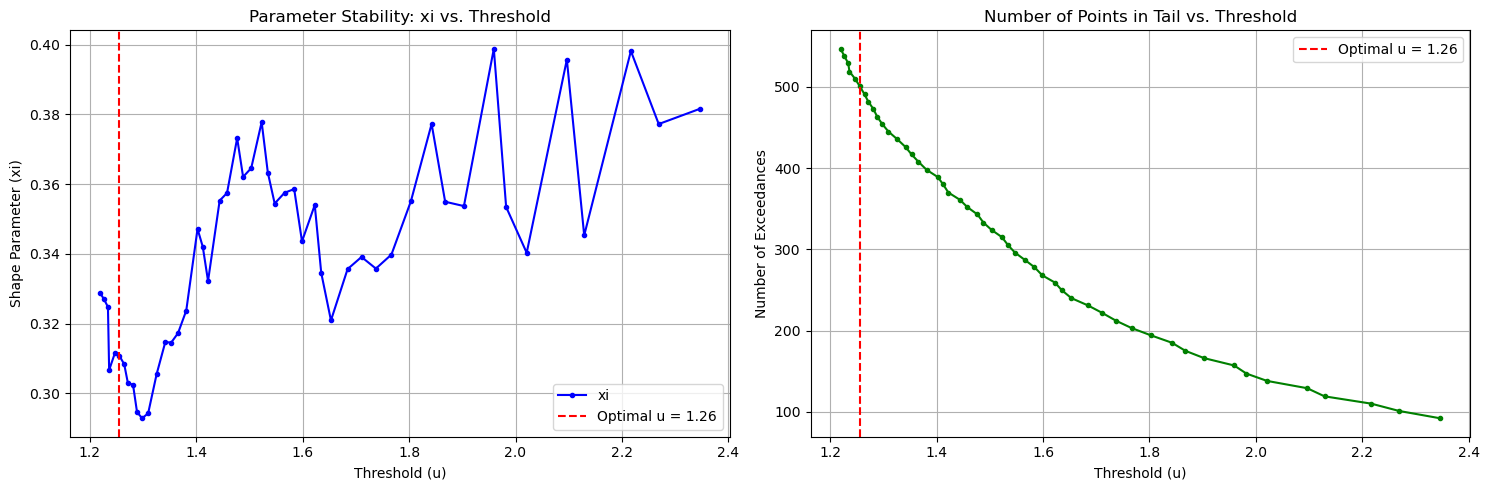

In [149]:
loss_series = prepare_evt_data(residuals)
optimal_threshold, exceedances, optimal_xi, optimal_beta = find_optimal_threshold(loss_series)

In [150]:
from scipy.stats import kstest
def pit_ks_test(exceedances, xi, beta):
    # Compute PIT (Probability Integral Transform)
    # CDF of GPD: F(x) = 1 - (1 + xi*x/beta)^(-1/xi)
    if xi == 0:
        pit = 1 - np.exp(-exceedances / beta)
    else:
        pit = 1 - (1 + xi * exceedances / beta) ** (-1 / xi)
    
    # KS test: compare PIT distribution to Uniform(0,1)
    ks_stat, p_value = kstest(pit, 'uniform')
    
    print(f"KS Statistic: {ks_stat:.4f}")
    print(f"KS p-value: {p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject H0: GPD fit is adequate (p > 0.05).")
    else:
        print("Reject H0: GPD fit may be inadequate (p <= 0.05).")
    
    return ks_stat, p_value

In [151]:
pit_ks_test(exceedances, optimal_xi, optimal_beta)

KS Statistic: 1.0000
KS p-value: 0.0000
Reject H0: GPD fit may be inadequate (p <= 0.05).


(0.9999999906829065, 1.863418708225595e-08)